<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/T_EBCM_markovian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulación usando EBCM markoviano.

Recordando las ecuaciones que lo definen.

$$\theta (t)=P(\text{ Test node u no ha recibido la infección al tiempo t } )$$
$$S(t)=\text{ Proporción de nodos susceptible = Probabilidad de que el test node sea susceptible}$$
$$S(t)+I(t)+R(t)=n$$
$$\psi =\text{ F.G.P de la distribución de grados.}$$
$$\beta,\gamma = \text{tasas de infección, recuperación.}$$


$$\dot{\theta}=-\beta \theta -\beta \frac{\psi'(\theta)}{\psi'(1)}-\gamma (1-\theta)$$
$$S(t)=\psi\left(\theta(t)\right)$$
$$I(t)=1-S(t)-R(t)$$
$$\dot{R}=\gamma I$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [13]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf,Tuto=False):
    flag=True

    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    X_R=0
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            X_I+=1
            X_S-=1
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):

                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            X_I-=1
            X_R+=1
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo
        if Tuto:
            print("Se genera el tiempo ",tau)
            print("Se selecciona al individuo",i)
            print("infectado por estar en el grupo con ", k_choice)
            nx.draw(G=G_network_initial,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
            plt.show()
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus

        if(X_I==0):
            flag=False
    return pd.DataFrame(Historia,columns=['time','S(t)','I(t)'])

In [14]:
N=1000
n=50
G=nx.fast_gnp_random_graph(n=N,p=n/N)
X_I_indexes=[0]
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
print("Empieza")
H=Gillespie_Direct_Method_Network(beta=1.25,gamma=1,N=N,X_I_indexes=[0],G_network_initial=G_copy,T=np.inf,Tuto=False)

Empieza


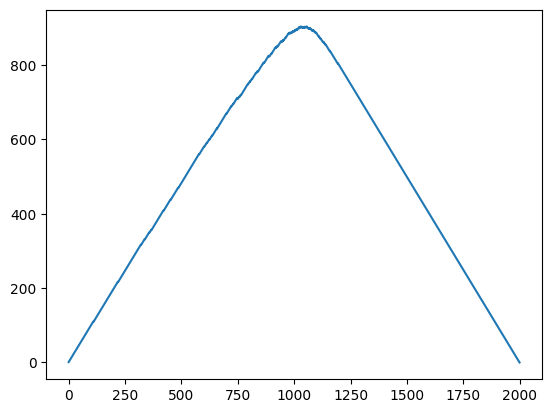

In [15]:
plt.plot(H['I(t)'])

## Ahora el EBCM

In [19]:
def psi(x):
    return ((1/31)*(25*x+5*x**5+x**25))
def psi_prime(x):
    return (1/31)*(25+25*x**4+25*x**24)

In [26]:
def EBCM(y, t, beta, gamma):
    theta, R = y
    dydt = [-beta*theta+beta*(psi(theta)/psi(1))+gamma*(1-theta), gamma*(1-psi(theta)-R)]
    return dydt

In [27]:
beta = 1.15
gamma = 1.0

In [37]:
y0 = [1-0.00001, 0.0]
t = np.linspace(0, 30, 301)

In [38]:
from scipy.integrate import odeint
sol = odeint(EBCM, y0, t, args=(beta, gamma))

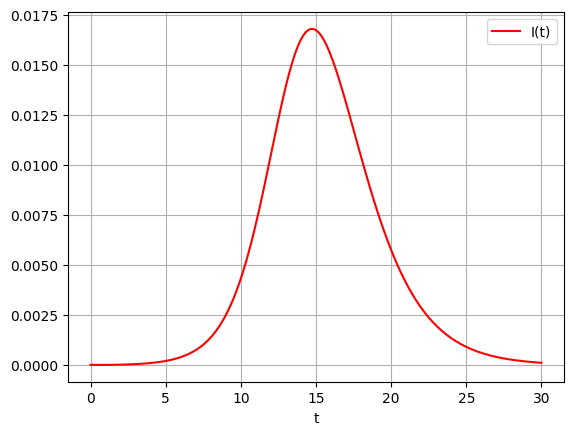

In [42]:
import matplotlib.pyplot as plt

plt.plot(t,1-psi(sol[:,0])-sol[:,1],'red',label='I(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()